<a href="https://colab.research.google.com/github/danieljai/CIND820-AndyLee/blob/main/AndyLee_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 3: Preload setup

Basic setup so results can utilize the full width of the screen.

In [50]:
%config IPCompleter.greedy=True
import pandas as pd

pd.set_option('display.max_colwidth', 200)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100

# Step 4: Import Dataset

The hydrated file is stored in a Google Drive, and using the follow code will mount Google Drive onto Colaboratory.

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
df = pd.read_csv("/content/drive/My Drive/__CIND 820 - Data Analytics Project/3-data/Book1-fastsave.csv")

# Step 5. Perform Data Cleaning

## Preview data after cleaning and manipulation

Original Tweet dataframe datatypes

In [53]:
# https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/user-object
df.dtypes

coordinates                    object
created_at                     object
hashtags                       object
media                          object
urls                           object
favorite_count                  int64
id                              int64
in_reply_to_screen_name        object
in_reply_to_status_id         float64
in_reply_to_user_id           float64
lang                           object
place                          object
possibly_sensitive             object
retweet_count                   int64
retweet_id                    float64
retweet_screen_name            object
source                         object
text                           object
tweet_url                      object
user_created_at                object
user_screen_name               object
user_default_profile_image       bool
user_description               object
user_favourites_count           int64
user_followers_count            int64
user_friends_count              int64
user_listed_

## Readjust attribute datatype

For `retweet_id`, `in_reply_to_status_id`, `in_reply_to_user_id`
- Convert `null` values to 0
- Convert attribute as int64

In [54]:
df.retweet_id = df[df['retweet_id'].notnull()].retweet_id.astype('int64') 

In [55]:
df.retweet_id = df.retweet_id.fillna(0).astype('int64')
df.in_reply_to_status_id = df.in_reply_to_status_id.fillna(0).astype('int64')
df.in_reply_to_user_id = df.in_reply_to_user_id.fillna(0).astype('int64')

In [56]:
df[['text']].sample(10)

,text
664426,"my birthday is in exactly 2 months, pls join me as we say a prayer for corona to be gone by then so i can be 21 &amp; have some fun"
158177,RT @vaishu0208: @SKedia7 @rpbreakingnews Indian Government has decided that anyone who is already in prison for 6 years will be released af…
623182,RT @sardesairajdeep: I know this will be seen as troll bait but @RahulGandhi was probably the first national politician to warn of an impen…
5391,They only believe in Sharia. #Nizamuddin https://t.co/BE7XAx42Dl
621696,RT @KammyTaughtYou: Y’all gotta stop telling people they gon avoid corona by simmering sangria on the stove. We need to start beating peopl…
646052,So they sent notice that IV had a confirmed corona case.\n\nHope they’re taking that shelter in place seriously.
55012,RT @Kaalateetham: I will not use it on my dog if it gets Corona.\n\nIt looks worse than amateur designing.\n\nWe are ready to spend more for mo…
669612,"RT @TheRickWilson: ""Trump was so distracted by impeachment he couldn't focus on Corona!""\n\nExcept when he was golfing about a dozen times be…"
564921,RT @StevenHyden5: RIP to the 13 year old boy who had no underlining illness that has died from corona virus\nMy heart goes out to his poor p…
40272,RT @ShefVaidya: Meet ‘atheist’ Jihad Akhtar. Jihad is not happy with Indian govt’s order to close all places of worship. Jihad wants a Fatw…


## Misc. cleaning up to reduce noise when conducting sentimental analysis
1. remove \n
2. remove URL
3. remove user referrals
4. remove hashtags

In [57]:
df['modified_text'] = df.text.str.replace(r'\n', '')
df['modified_text'] = df.modified_text.str.replace(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '')
df['modified_text'] = df.modified_text.str.replace(r'\B@\w+', '')
df['modified_text'] = df.modified_text.str.replace(r'\B#\w+', '')

## Splitting Dataframes (originals and retweets)

The collection includes both original tweets and retweets. Since retweets mirrors the original tweet by someone else other than the author, we don't need to run sentimental analysis on the retweet as it would have been run on the original tweet, therefore we can split original tweets and retweets into two dataframes to avoid wasting resources.


- Original tweets: `dfOriginals`
- Retweets: `dfRetweets` cons





In [58]:
dfOriginals = df[df.retweet_id == 0]
dfRetweets = df[df.retweet_id != 0]

Two samples of the original tweet dataframe.

In [59]:
dfOriginals.sample(2)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,retweet_count,retweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_screen_name,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,modified_text
205414,NaN,Tue Mar 31 11:18:23 +0000 2020,NaN,NaN,NaN,29,1244947142155702275,NaN,0,0,en,NaN,NaN,3,0,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",Choonawallah is legit asking Tableeghi Jamat to be banned in India even if it was not about Corona.,https://twitter.com/mehdi_nisar1/status/1244947142155702275,Wed Jun 30 11:46:13 +0000 2010,mehdi_nisar1,False,Bandey Hai Hum USKE.,47523,7749,1831,29,Bangalore,ನಿಸಾರ್ ( R C B ),mehdi_nisar1,151173,NaN,NaN,False,Choonawallah is legit asking Tableeghi Jamat to be banned in India even if it was not about Corona.
321952,NaN,Tue Mar 31 14:15:26 +0000 2020,NaN,NaN,https://twitter.com/KristenMorozin/status/1244989822491557891,1,1244991698192814088,NaN,0,0,en,NaN,False,0,0,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",a lyrical genius https://t.co/RE4lnIzw4F,https://twitter.com/rachelxx7_/status/1244991698192814088,Sat Apr 14 00:46:27 +0000 2012,rachelxx7_,False,probably complaining | she/her,94692,363,179,4,NaN,lil rachie ✨,rachelxx7_,76210,NaN,http://instagram.com/rachel7x,False,a lyrical genius


## Guessing language

Since our sentiment analysis focuses on only English tweets, we will install a `langdetect` library to help filter out tweets that are not English.

In [60]:
#https://pypi.org/project/langdetect/
!pip install langdetect
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0



Function to test whether tweet is English with error handling.

In [61]:
#https://stackoverflow.com/questions/60930935/exclude-non-english-rows-in-pandas

def is_en(txt):
    try:
        return detect(txt)=='en'
    except:
        return False

Passing as the `is_en()` as first-class function; returning a boolean value as a attribute `guessed_language`.

In [62]:
dfOriginals['guessed_language'] = dfOriginals.modified_text.apply(is_en)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


By filtering out non-English tweets, we remove noise that can potentially affect our sentimental analysis.

In [63]:
print("There are " + str(len(dfOriginals)) + " tweets, and " + str(sum(dfOriginals.guessed_language)) + " ("+str(round((sum(dfOriginals.guessed_language) / len(dfOriginals)) * 100, 2))+"%) tweets detected as English.")

There are 245389 tweets, and 232816 (94.88%) tweets detected as English.


# Step 6. Conduct Sentiment Analysis

To conduct Seitment Analysis, we begin by importing the NLTK library.

In [64]:
import nltk
from nltk.sentiment.util import *
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
nltk.download('punkt')
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Applying Sentiment Analysis function

We apply the polarity score function and store results on a new attribute `sentimentscore`.



In [65]:
dfOriginals['sentimentscore'] = dfOriginals.modified_text.apply(sid.polarity_scores)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


A quick sample preview of the text and its sentiment score.

In [66]:
dfOriginals.sample(2)[['modified_text','sentimentscore']]

,modified_text,sentimentscore
375022,Bottle of Corona?,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
690809,Its not being blessed. U buy things which dont get spoiled fast. A kg costs only 15 rupees and 12 kgs costs only 180 i can survive just on that for more than a week without having to look at rice wheat and dal. My diet was 90% fruits and raw veggies even before Corona!!!,"{'neg': 0.074, 'neu': 0.926, 'pos': 0.0, 'compound': -0.6152}"


The `SentimentIntensityAnalyzer()` returns a dictionary of scores negative, neutral, positive, and compound. Compound is the normalization of negative, neutral, and positive values.


How compound is calculated? https://stackoverflow.com/questions/40325980/how-is-the-vader-compound-polarity-score-calculated-in-python-nltk

Next, we expand the score, which is currently as dictionary, into their own attributes for better data manipulation--especially the compound attribute.

In [67]:
dfOriginalSScore = pd.json_normalize(dfOriginals.sentimentscore)
dfOriginalSScore['original_index'] = dfOriginals.index
dfOriginalSScore = dfOriginalSScore.set_index('original_index')

Merge the dataframe with sentiment scores and the dataframe with the original tweets together, onto a new dataframe `dfOriginals_Analyzed`.

In [68]:
dfOriginals_Analyzed = dfOriginals.merge(dfOriginalSScore, left_index=True, right_index=True)

Quick preview of modified text and compound on the merged dataframe.

In [69]:
dfOriginals_Analyzed.sample(10)[['modified_text','compound']]

,modified_text,compound
721216,That’s NOT the truth. It’s an idiot without any knowledge or experience about it spouting his ignorance.There are a lot of idiots like that with EVERY happening. From 911 to Corona.,-0.4141
479225,For your next music from home video I feel you should perform a rewritten Corona-themed version of the Dukes of Hazzard.,0.0000
636958,"why, is the governor from Lakewood or throwing Corona parties;-) seriously, some of this is people acting irresponsibly when they know better --but they just don't want to or they think the restrictions don't apply to them personally and are just for other people.",0.2448
39852,"So many Commissions ,post-corona. Money shall be chowed.",0.0000
54044,"It's been quite clear since the beginning of his presidency, but never has it been more obvious that Cyril doesn't give a damn about the economy or well-being of South Africans. He's merely using the corona virus as an excuse and distraction for his own failures.",-0.4795
643628,Account for Corona Relief Fund is working well.,0.6369
273206,"I agree with what you're saying, but it's most likely she died from corona",-0.6752
751819,Hopefully by the grace of god this corona-virus pandemic will end in America by the summer or the winter like September or November god willing this doesn't last for the rest of the year.,0.8807
117734,Because many people do. Would you be happier if they hadn't?,0.5267
127644,I am from Dharavi Mumbai 400017 here we all people use public toilets which are not senitized due to which risk of Corona virus is much because in a day on every toilet 1000+ people go there please share this issue with government authority through your media,0.4019


We binning based on compound scores
* -1 to -0.1 = negative 
* -0.1 to 0.1  = neutral
* 0.1 to 1 = positive

The threshold chosen is based on the paper "Predictive Analysis of Resource Usage Data in Academic Libraries using the VADER Sentiment Algorithm"

Deo, G. S., Mishra, A., Jalaluddin, Z. M., & Mahamuni, C. V. (2020, September). Predictive Analysis of Resource Usage Data in Academic Libraries using the VADER Sentiment Algorithm. In 2020 12th International Conference on Computational Intelligence and Communication Networks (CICN) (pp. 221-228). IEEE.

https://www.researchgate.net/profile/Gouri_Deo/publication/342988903_Predictive_Analysis_of_Resource_Usage_Data_in_Academic_Libraries_using_the_VADER_Sentiment_Algorithm/links/5f1085a6a6fdcc3ed70bcf20/Predictive-Analysis-of-Resource-Usage-Data-in-Academic-Libraries-using-the-VADER-Sentiment-Algorithm.pdf



In [70]:
dfOriginals_Analyzed['sentiment_class_relaxed'] = pd.cut(dfOriginals_Analyzed['compound'], bins=[-1, -0.1, 0.1, 1], right=True, labels=['neg', 'neu', 'pos'])
dfOriginals_Analyzed.sentiment_class_relaxed.value_counts()

neg    89051
pos    84039
neu    72299
Name: sentiment_class_relaxed, dtype: int64

# Step 7. Conduct Basic Analysis

Observing the correlation between variables.

In [71]:
dfOriginals_Analyzed[['favorite_count','retweet_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']].corr()

,favorite_count,retweet_count,user_followers_count,compound,user_statuses_count,user_favourites_count,user_friends_count,user_listed_count
favorite_count,1.000000,0.908576,0.165683,-0.001108,0.015366,0.007852,0.005575,0.051646
retweet_count,0.908576,1.000000,0.090025,-0.003071,0.015991,0.007261,0.007084,0.039251
user_followers_count,0.165683,0.090025,1.000000,0.003693,0.116452,0.000535,0.032721,0.609057
compound,-0.001108,-0.003071,0.003693,1.000000,-0.022604,-0.028941,-0.006560,0.000249
user_statuses_count,0.015366,0.015991,0.116452,-0.022604,1.000000,0.326723,0.105958,0.128835
user_favourites_count,0.007852,0.007261,0.000535,-0.028941,0.326723,1.000000,0.100920,0.016049
user_friends_count,0.005575,0.007084,0.032721,-0.006560,0.105958,0.100920,1.000000,0.048344
user_listed_count,0.051646,0.039251,0.609057,0.000249,0.128835,0.016049,0.048344,1.000000


In [72]:
dfOriginals_Analyzed[['favorite_count','retweet_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,favorite_count,retweet_count,user_followers_count,compound,user_statuses_count,user_favourites_count,user_friends_count,user_listed_count
count,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000
mean,9.52971,2.70475,9251.20519,-0.01655,27468.30799,18028.51423,1284.43071,34.64758
std,384.21091,122.27732,250678.23602,0.47919,75560.36124,39592.12977,10409.72569,680.04372
min,0.00000,0.00000,0.00000,-0.99520,1.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,64.00000,-0.39760,1156.00000,510.00000,135.00000,0.00000
50%,0.00000,0.00000,331.00000,0.00000,6344.00000,4200.00000,399.00000,1.00000
75%,1.00000,0.00000,1307.00000,0.36120,24616.00000,17807.00000,1038.00000,6.00000
max,108137.00000,35137.00000,62855265.00000,0.99190,4472178.00000,1254400.00000,4322723.00000,202433.00000


Plot Distribution of sentiment scores

The histogram shows the distribution appears to have some modes, and rather symmetric.

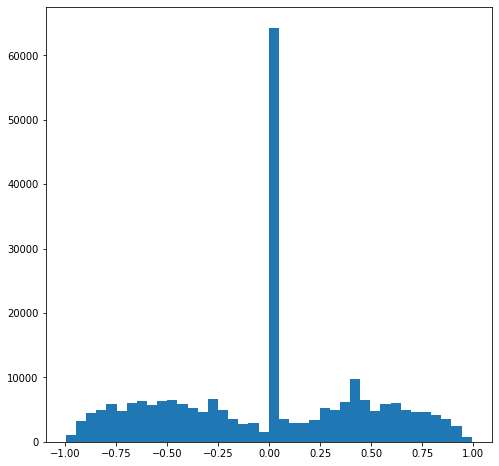

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8)) 
histo_plot = plt.hist(dfOriginals_Analyzed['compound'],bins=40)


(-1.1182944691568912,
 1.1129382929025038,
 -1.1162563432183583,
 1.1007741115818266)

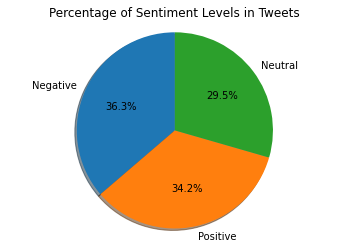

In [74]:
# Plot pie chart
# 

fig1, ax1 = plt.subplots()
ax1.pie(dfOriginals_Analyzed.sentiment_class_relaxed.value_counts().values, labels=dfOriginals_Analyzed.sentiment_class_relaxed.value_counts().index.rename_categories(['Negative','Neutral','Positive']), autopct='%1.1f%%', shadow=True, startangle=90)
ax1.title.set_text("Percentage of Sentiment Levels in Tweets")
ax1.axis('equal')

# Step 8. Build Prediction Model for "Favourite Count" with Linear Regression

## Split Train and Test set

In [75]:
from sklearn import preprocessing
from sklearn import linear_model



independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']
dependent_variables = 'favorite_count'


trainSet=dfOriginals_Analyzed.sample(frac=0.8,random_state=150)
testSet=dfOriginals_Analyzed.drop(trainSet.index)

X_train = trainSet[independent_variables]
Y_train = trainSet[dependent_variables]
X_test = testSet[independent_variables]
Y_test = testSet[dependent_variables]
reg = linear_model.LinearRegression()

reg.fit(X_train,Y_train)

print('Coefficient\tLabel\n===========================================')
coefficient_list = (list(zip(reg.coef_, independent_variables)))
for el in coefficient_list:
  print('{: 4f}\t{}'.format(*el))

print(f"\nR^2-score (train set): {reg.score(X_train,Y_train):4f}")


Coefficient	Label
 2.536713	retweet_count
 0.000211	user_followers_count
 1.016376	compound
-0.000038	user_statuses_count
 0.000057	user_favourites_count
-0.000056	user_friends_count
-0.034559	user_listed_count

R^2-score (train set): 0.799859


Since this is a regression model with continous values, we use Mean Square Error (MSE), Root MSE, and R-square metrics to measure the performance of the model. 

reference: https://stackoverflow.com/questions/49103139/calculating-accuracy-scores-of-predicted-continuous-values

In [76]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from math import sqrt

# Run prediction; Concating results onto a single dataframe; rounding prediction numbers as integer.
plot_1_Y = reg.predict(X_test) # predicted as Y
plot_1_X = Y_test.reset_index()  # actual as X
df_plot_1 = pd.concat([plot_1_X,pd.DataFrame(plot_1_Y)],axis=1)
df_plot_1.columns = ['index','actual', 'predicted']
df_plot_1.predicted = round(df_plot_1.predicted,0).astype(int)

mse = mean_squared_error(df_plot_1.actual, df_plot_1.predicted)
mae = mean_absolute_error(df_plot_1.actual, df_plot_1.predicted)
r2 = r2_score(df_plot_1.actual, df_plot_1.predicted)
adj_r2 = 1-(1-r2)*(len(df_plot_1.actual)-1)/(len(df_plot_1.actual)-len(independent_variables)-1)
print("\nMetrics\n============================================")
print(f"Mean Square Error (MSE): {mse:4f}")
print(f"Root MSE:\t\t {sqrt(mse):4f}")
print(f"Mean Absolute Error:\t {mae:4f}")
print(f"R^2:\t\t\t {r2:4f}")
print(f"Adjusted R-Square:\t {adj_r2:4f}")




Metrics
Mean Square Error (MSE): 33404.189046
Root MSE:		 182.768129
Mean Absolute Error:	 7.281756
R^2:			 0.873217
Adjusted R-Square:	 0.873199


Scatterplot to visually observe how well the model's prediction vs actual value.

Text(0.5, 0, 'Actual values (favorite_count)')

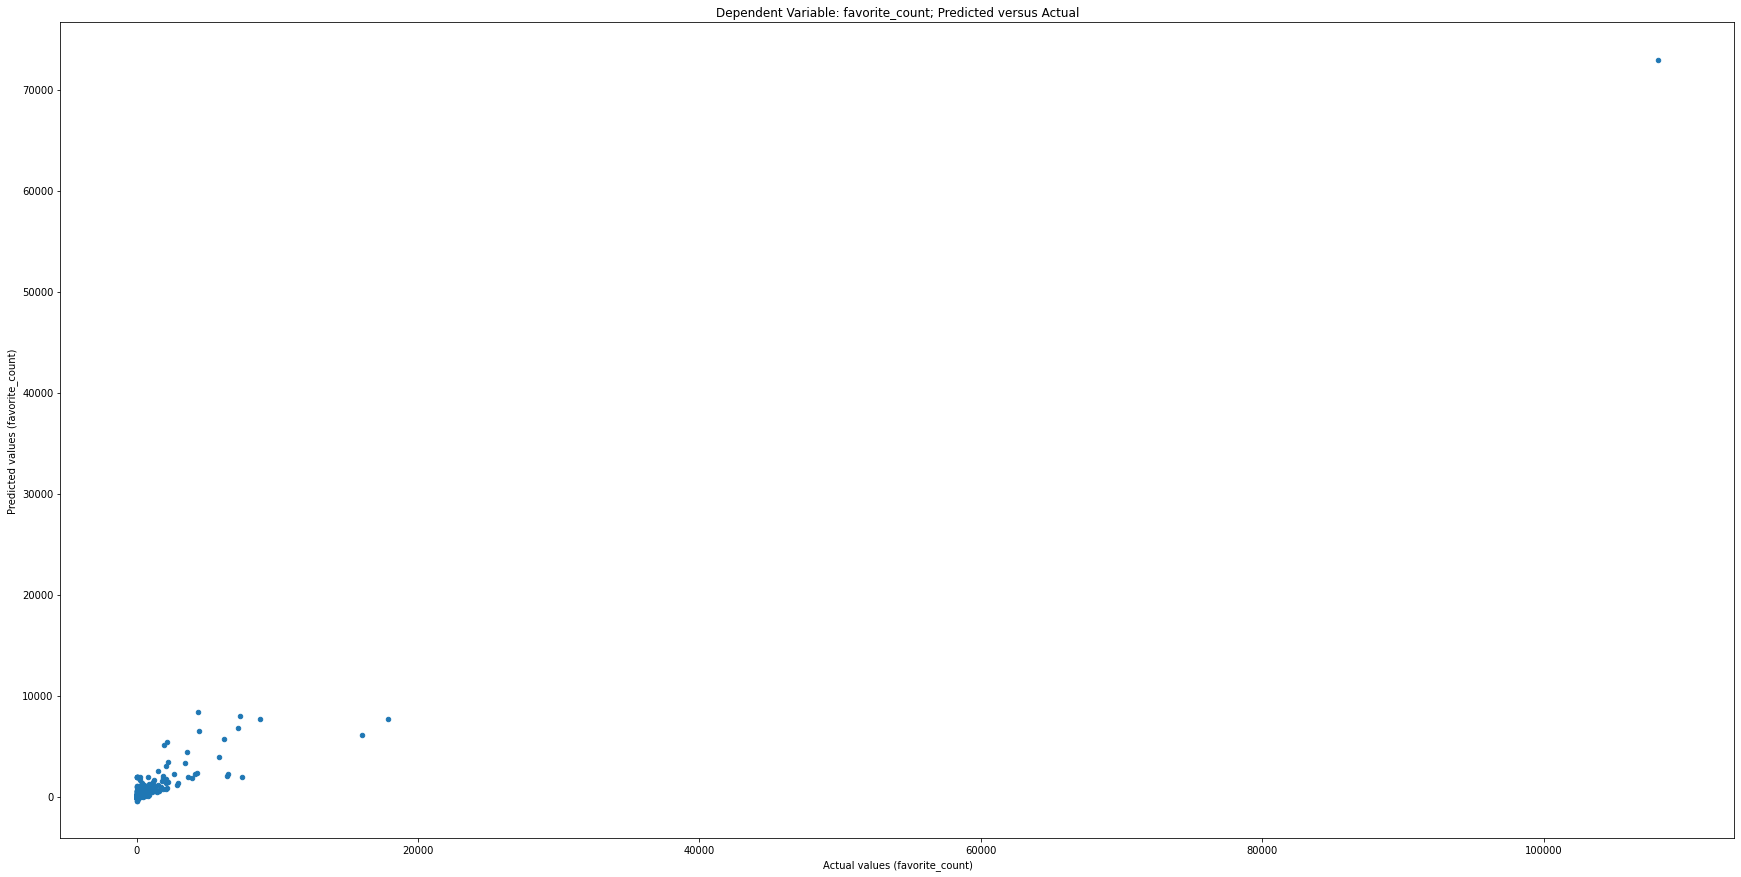

In [77]:
from numpy.polynomial.polynomial import polyfit
import numpy as np


plot_1 = df_plot_1.plot.scatter(x='actual',y='predicted',figsize=(30,15),title="Dependent Variable: " + dependent_variables + "; Predicted versus Actual")
plot_1.set_ylabel("Predicted values (" + dependent_variables + ")")
plot_1.set_xlabel("Actual values (" + dependent_variables + ")")



Since our outliers are distorting the scatterplot visually, we will limit the observation to 2-sigma (95%).

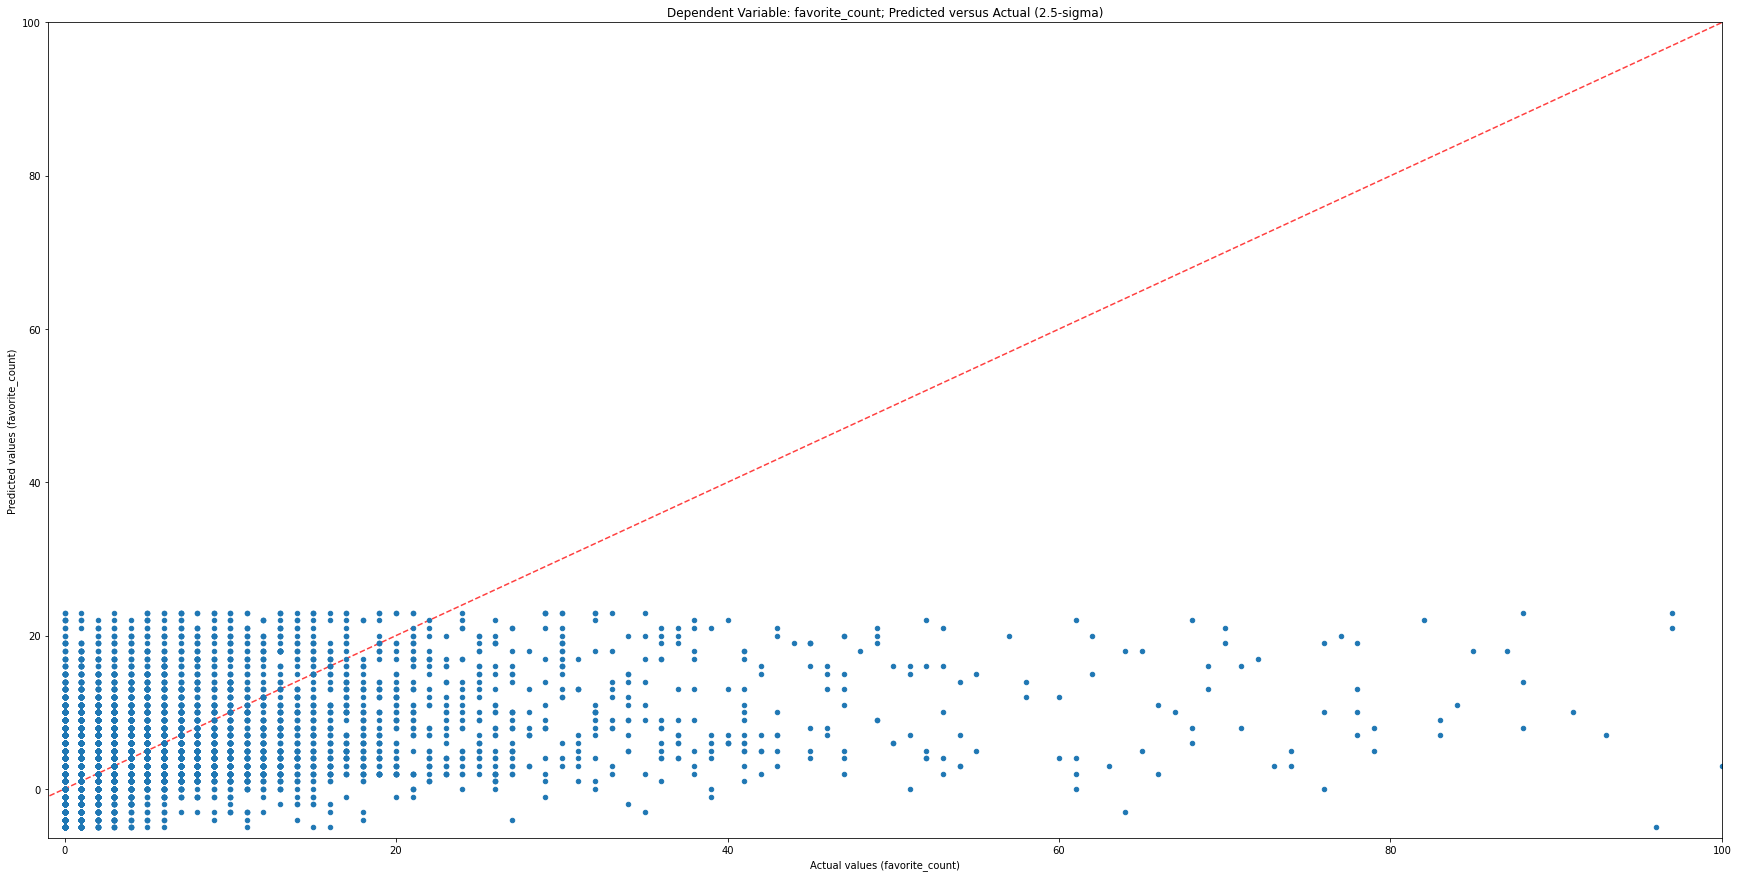

In [78]:
df_plot_2 = df_plot_1[df_plot_1.predicted.between(df_plot_1.predicted.quantile(0.025), df_plot_1.predicted.quantile(0.975))]
# df_plot_2 = df_plot_1[df_plot_1.predicted.between(df_plot_1.predicted.quantile(0.0015), df_plot_1.predicted.quantile(0.9985))]
plot_2 = df_plot_2.plot.scatter(x='actual',y='predicted',figsize=(30,15),title="Dependent Variable: " + dependent_variables + "; Predicted versus Actual (2.5-sigma)")
plot_2.set_ylabel("Predicted values (" + dependent_variables + ")")
plot_2.set_xlabel("Actual values (" + dependent_variables + ")")
plot_2.set_ylim(top=100)
plot_2.set_xlim(right=100)
plot_2.set_xlim(left=-1)




# b, m = polyfit(df_plot_2.actual, df_plot_2.predicted, 1)
# plot_2.plot(df_plot_2.actual, b + m * df_plot_2.actual, '-')

lims = [
    np.min([plot_2.get_xlim(), plot_2.get_ylim()]),  # min of both axes
    np.max([plot_2.get_xlim(), plot_2.get_ylim()]),  # max of both axes
]
plot_2.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

# Step 9. Build Prediction Model for "Retweet Count" with Linear Regression

## Split Train and Test set

In [79]:
from sklearn import preprocessing
from sklearn import linear_model

independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']
dependent_variables = 'retweet_count'

trainSet=dfOriginals_Analyzed.sample(frac=0.8,random_state=150)
testSet=dfOriginals_Analyzed.drop(trainSet.index)

X_train = trainSet[independent_variables]
Y_train = trainSet[dependent_variables]
X_test = testSet[independent_variables]
Y_test = testSet[dependent_variables]
reg = linear_model.LinearRegression()

reg.fit(X_train,Y_train)

# print("Coefficients: " + ', '.join(independent_variables))
# print(reg.coef_)
print('Coefficient\tLabel\n===========================================')
coefficient_list = (list(zip(reg.coef_, independent_variables)))
for el in coefficient_list:
  print('{: 4f}\t{}'.format(*el))

print(f"\nR^2-score (train set): {reg.score(X_train,Y_train):4f}")


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from math import sqrt

# Run prediction; Concating results onto a single dataframe; rounding prediction numbers as integer.
plot_1_Y = reg.predict(X_test) # predicted as Y
plot_1_X = Y_test.reset_index()  # actual as X
df_plot_1 = pd.concat([plot_1_X,pd.DataFrame(plot_1_Y)],axis=1)
df_plot_1.columns = ['index','actual', 'predicted']
df_plot_1.predicted = round(df_plot_1.predicted,0).astype(int)



mse = mean_squared_error(df_plot_1.actual, df_plot_1.predicted)
mae = mean_absolute_error(df_plot_1.actual, df_plot_1.predicted)
r2 = r2_score(df_plot_1.actual, df_plot_1.predicted)
adj_r2 = 1-(1-r2)*(len(df_plot_1.actual)-1)/(len(df_plot_1.actual)-len(independent_variables)-1)
print("\nMetrics\n============================================")
print(f"Mean Square Error (MSE): {mse:4f}")
print(f"Root MSE:\t\t {sqrt(mse):4f}")
print(f"Mean Absolute Error:\t {mae:4f}")
print(f"R-Square:\t\t {r2:4f}")
print(f"Adjusted R-Square:\t {adj_r2:4f}")


Coefficient	Label
 0.311235	favorite_count
-0.000055	user_followers_count
-0.449341	compound
 0.000013	user_statuses_count
-0.000014	user_favourites_count
 0.000025	user_friends_count
 0.009861	user_listed_count

R^2-score (train set): 0.791882

Metrics
Mean Square Error (MSE): 1234.588084
Root MSE:		 35.136706
Mean Absolute Error:	 1.967480
R-Square:		 0.934187
Adjusted R-Square:	 0.934178


Scatterplot of Predicted value vs Actual Value.

In [80]:
(sum((df_plot_1.actual - df_plot_1.predicted) ** 2)) / len(df_plot_1.actual)

1234.5880842740128

Text(0.5, 0, 'Actual values (retweet_count)')

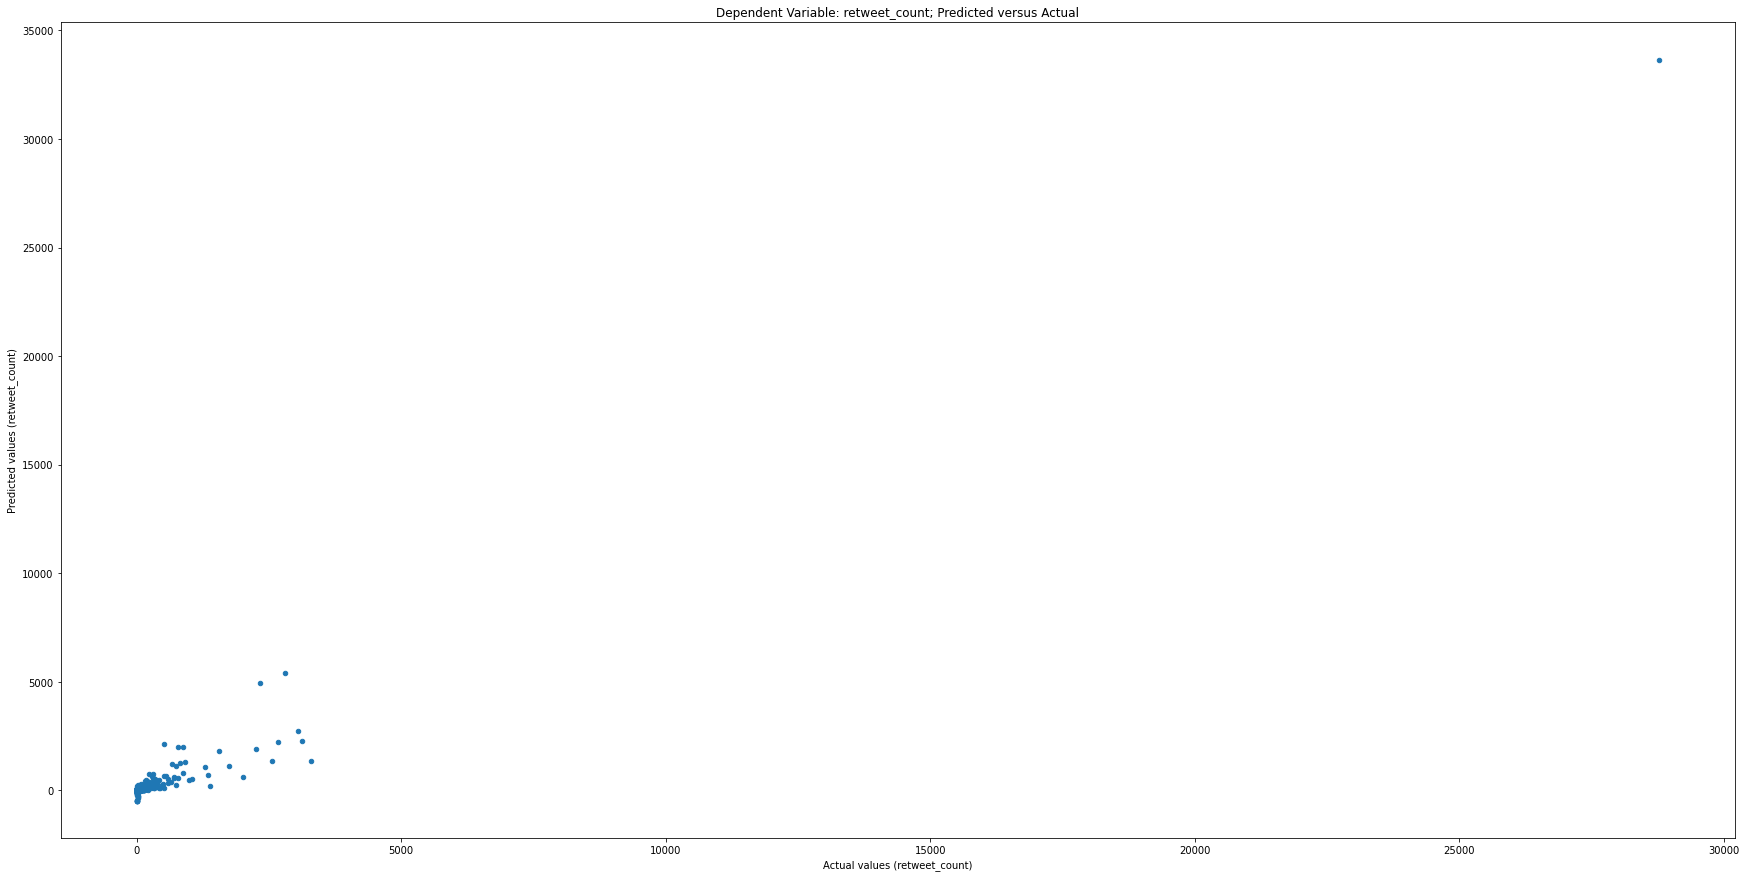

In [81]:
from numpy.polynomial.polynomial import polyfit

plot_1 = df_plot_1.plot.scatter(x='actual',y='predicted',figsize=(30,15),title="Dependent Variable: " + dependent_variables + "; Predicted versus Actual")
plot_1.set_ylabel("Predicted values (" + dependent_variables + ")")
plot_1.set_xlabel("Actual values (" + dependent_variables + ")")




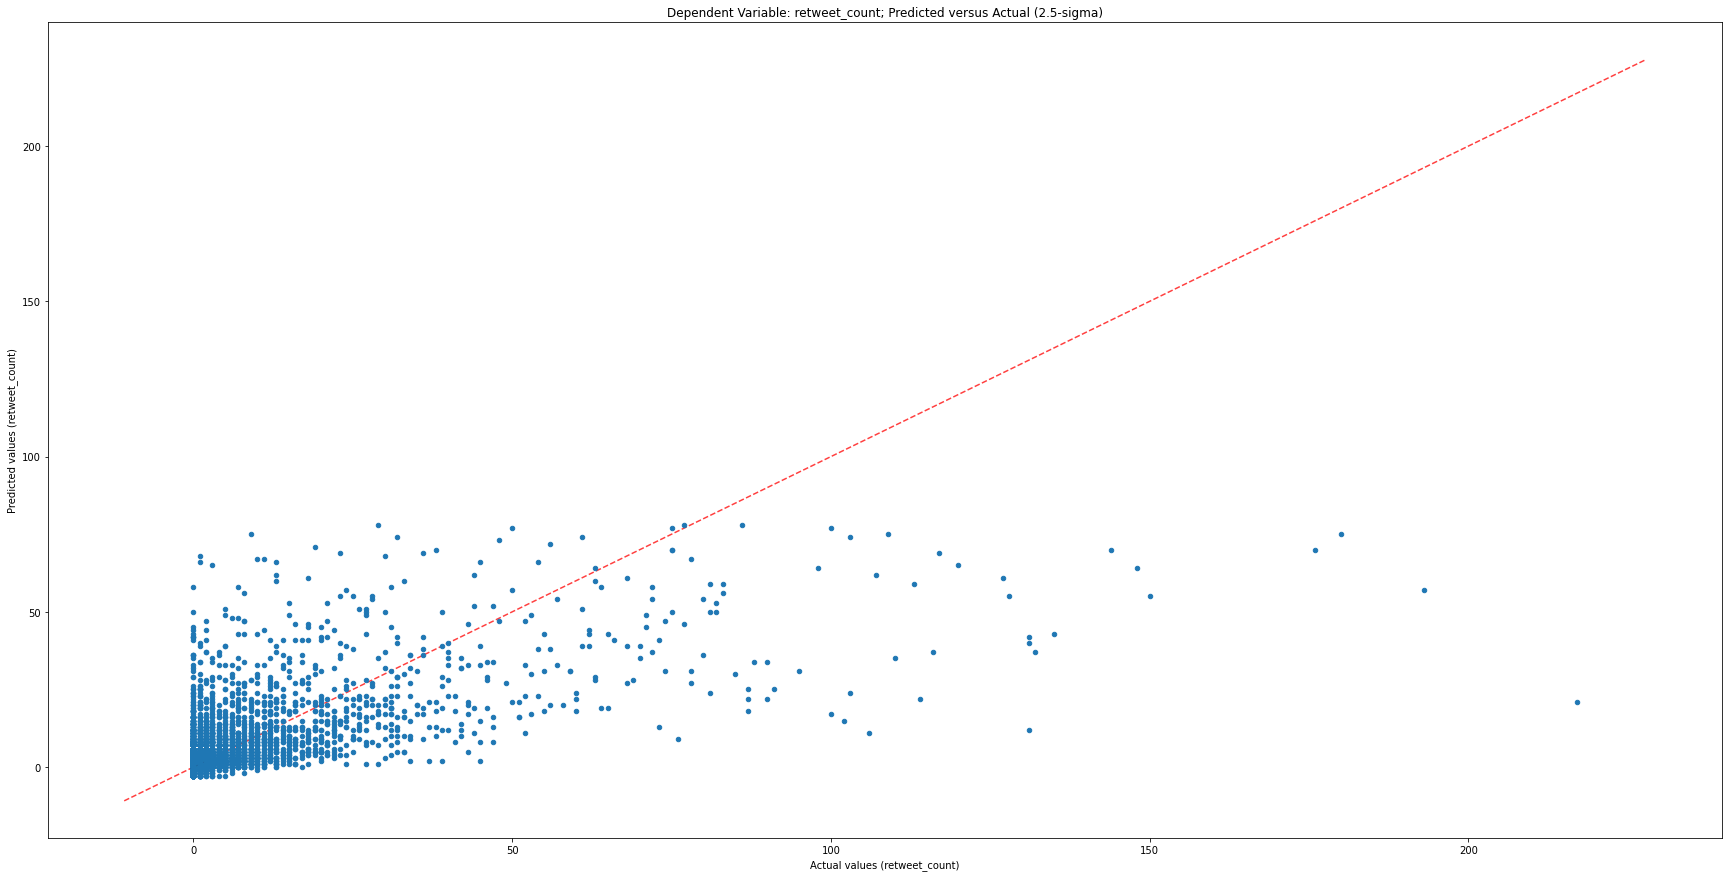

In [82]:
# Scatterplot covering 2.5-sigma.
df_plot_2 = df_plot_1[df_plot_1.predicted.between(df_plot_1.predicted.quantile(.0031), df_plot_1.predicted.quantile(0.9969))]
plot_2 = df_plot_2.plot.scatter(x='actual',y='predicted',figsize=(30,15),title="Dependent Variable: " + dependent_variables + "; Predicted versus Actual (2.5-sigma)")
plot_2.set_ylabel("Predicted values (" + dependent_variables + ")")
plot_2.set_xlabel("Actual values (" + dependent_variables + ")")

# b, m = polyfit(df_plot_2.actual, df_plot_2.predicted, 1)
# plot_2.plot(df_plot_2.actual, b + m * df_plot_2.actual, '-')

lims = [
    np.min([plot_2.get_xlim(), plot_2.get_ylim()]),  # min of both axes
    np.max([plot_2.get_xlim(), plot_2.get_ylim()]),  # max of both axes
]
plot_2.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

# Step 10: Build Linear Regression with k-Fold

Since the metrics we got from the previous regression consist of only one sampling, we should implement the same regression model using K-fold cross-validation in order to get more accurate metrics.

In [83]:
# K-fold - #1 favourite count as dependent
#
# References:
# https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold
# https://stackoverflow.com/questions/57398411/next-always-gives-the-same-index-with-a-kfold-generator
# https://machinelearningmastery.com/k-fold-cross-validation/
# https://machinelearningmastery.com/robust-regression-for-machine-learning-in-python/
from sklearn.model_selection import KFold

independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']
dependent_variables = 'favorite_count'


kfold_n = 5
kfold_mse_total, kfold_rmse_total, kfold_rsqr_total = 0, 0, 0
kf = KFold(n_splits = kfold_n, shuffle = True, random_state = 2)

# Excluding outliers, only including within 3-sigma
# dfKfold = dfOriginals_Analyzed[dfOriginals_Analyzed[dependent_variables].between(dfOriginals_Analyzed[dependent_variables].quantile(.0015), dfOriginals_Analyzed[dependent_variables].quantile(0.9985))]
dfKfold = dfOriginals_Analyzed

kf_result = kf.split(dfKfold)

print("Dependent Variable: {}".format(dependent_variables))
print("Independent Variables: {}".format(independent_variables))
print("K-fold: {}".format(kfold_n))
print("MSE\t\t\tRMSE\t\t\tR-Square\n=============================================================================================")

for train_idx, test_idx in kf_result:
  # print(train_idx)
  trainSet=dfKfold.iloc[train_idx]
  testSet=dfKfold.iloc[test_idx]

  X_train = trainSet[independent_variables]
  Y_train = trainSet[dependent_variables]
  X_test = testSet[independent_variables]
  Y_test = testSet[dependent_variables]

  reg = linear_model.LinearRegression()

  reg.fit(X_train,Y_train)

  y_test_pred = reg.predict(X_test) 

  mse = mean_squared_error(Y_test, y_test_pred)
  rsqr = r2_score(Y_test, y_test_pred)
  # print("Mean Square Error (MSE): " + str(mse))
  # print("Root MSE: " + str(sqrt(mse)))
  # print("R-Square: " + )

  print(f"{mse:4f}\t\t{sqrt(mse):4f}\t\t{rsqr:4f}")

  kfold_mse_total += mse
  kfold_rmse_total += sqrt(mse)
  kfold_rsqr_total += rsqr

print("\nAverage\n=============================================================================================")
print(f"{kfold_mse_total / kfold_n:4f}\t\t{kfold_rmse_total / kfold_n:4f}\t\t{kfold_rsqr_total / kfold_n:4f}")




Dependent Variable: favorite_count
Independent Variables: ['retweet_count', 'user_followers_count', 'compound', 'user_statuses_count', 'user_favourites_count', 'user_friends_count', 'user_listed_count']
K-fold: 5
MSE			RMSE			R-Square
31564.218170		177.663216		0.877825
10521.044828		102.572145		0.704872
130028.329157		360.594411		0.378130
10211.723622		101.053073		0.782832
13119.346895		114.539718		0.930201

Average
39088.932535		171.284512		0.734772


In [84]:
# K-fold #2 Retweet as independent
#

from sklearn.model_selection import KFold


independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']
dependent_variables = 'retweet_count'

kfold_n = 5
kfold_mse_total, kfold_rmse_total, kfold_rsqr_total = 0, 0, 0
kf = KFold(n_splits = kfold_n, shuffle = True, random_state = 2)

dfKfold = dfOriginals_Analyzed

kf_result = kf.split(dfKfold)

print("Dependent Variable: {}".format(dependent_variables))
print("Independent Variables: {}".format(independent_variables))
print("K-fold: {}".format(kfold_n))
print("MSE\t\t\tRMSE\t\t\tR-Square\n=============================================================================================")

for train_idx, test_idx in kf_result:
  # print(train_idx)
  trainSet=dfKfold.iloc[train_idx]
  testSet=dfKfold.iloc[test_idx]

  X_train = trainSet[independent_variables]
  Y_train = trainSet[dependent_variables]
  X_test = testSet[independent_variables]
  Y_test = testSet[dependent_variables]

  reg = linear_model.LinearRegression()

  reg.fit(X_train,Y_train)

  y_test_pred = reg.predict(X_test) 

  mse = mean_squared_error(Y_test, y_test_pred)
  rsqr = r2_score(Y_test, y_test_pred)

  print(f"{mse:4f}\t\t{sqrt(mse):4f}\t\t{rsqr:4f}")

  kfold_mse_total += mse
  kfold_rmse_total += sqrt(mse)
  kfold_rsqr_total += rsqr

print("\nAverage\n=============================================================================================")
print(f"{kfold_mse_total / kfold_n:4f}\t\t{kfold_rmse_total / kfold_n:4f}\t\t{kfold_rsqr_total / kfold_n:4f}")





Dependent Variable: retweet_count
Independent Variables: ['favorite_count', 'user_followers_count', 'compound', 'user_statuses_count', 'user_favourites_count', 'user_friends_count', 'user_listed_count']
K-fold: 5
MSE			RMSE			R-Square
1001.568224		31.647563		0.945563
798.111384		28.250865		0.605363
10974.758804		104.760483		0.685319
728.033332		26.982093		0.750776
666.921016		25.824814		0.959674

Average
2833.878552		43.493164		0.789339


# Step 11: Build Polynomial Regression

Here we attempt to fit our model onto a non-linear regression model--Polynomial regression model to see whether we are able to build a better fit of the model than linear regression.

R-squared values: 

Polynomial degree 1: test score=0.87
Polynomial degree 2: test score=0.72
Polynomial degree 3: test score=-5.57
Polynomial degree 6: test score=0.11


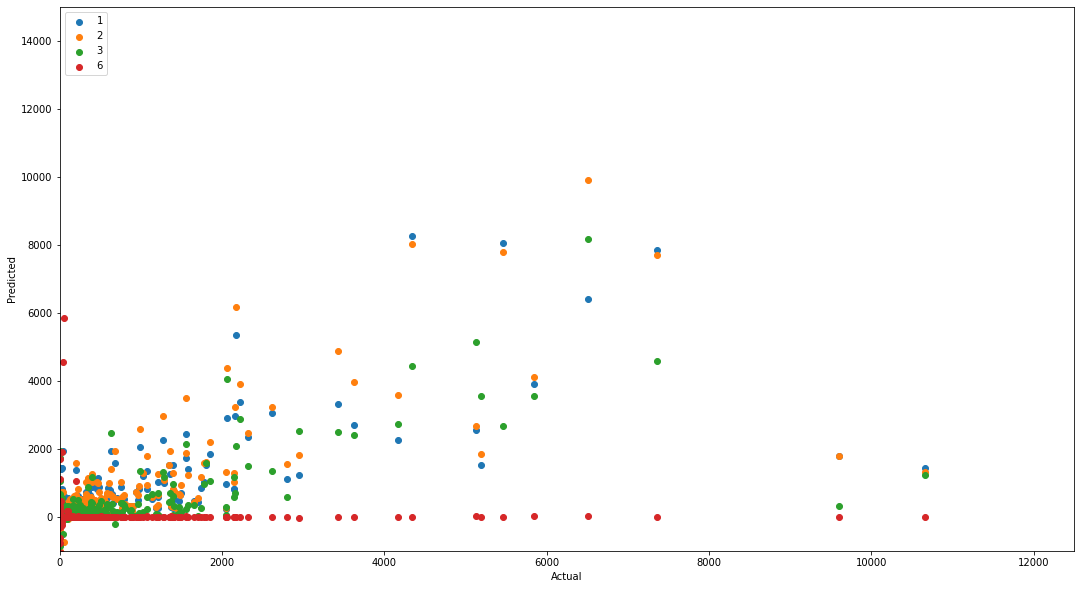

In [85]:
# POLYNOMIAL REGRESSION #1 favorite_count
#
# Reference
# https://www.kaggle.com/jnikhilsai/cross-validation-with-linear-regression

import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_verified']
dependent_variables = 'favorite_count'
# independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_verified']
# dependent_variables = 'retweet_count'
degrees = [1, 2, 3, 6]

# excluding Outliners
# dfPoly = dfOriginals_Analyzed[dfOriginals_Analyzed[dependent_variables].between(dfOriginals_Analyzed[dependent_variables].quantile(.0015), dfOriginals_Analyzed[dependent_variables].quantile(0.9985))]
dfPoly = dfOriginals_Analyzed

trainSet=dfPoly.sample(frac=0.8,random_state=200)
testSet=dfPoly.drop(trainSet.index)


X_train = trainSet[independent_variables]
Y_train = trainSet[dependent_variables]
X_test = testSet[independent_variables]
Y_test = testSet[dependent_variables]

# y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

# calculate values for each degree
for i, degree in enumerate(degrees):    
    model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
    model.fit(X_train, Y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    # y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)
  
# plot the graph
plt.figure(figsize=(40, 10))
plt.subplot(121)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.ylim([-1000,15000])
plt.xlim([0,12500])
for i, degree in enumerate(degrees):    
    plt.scatter(Y_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')


# print metrics
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    test_r2 = round(r2_score(Y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: test score={1}".format(degree, test_r2))

R-squared values: 

Polynomial degree 1: test score=0.94
Polynomial degree 2: test score=0.08
Polynomial degree 3: test score=0.01
Polynomial degree 6: test score=-422.7


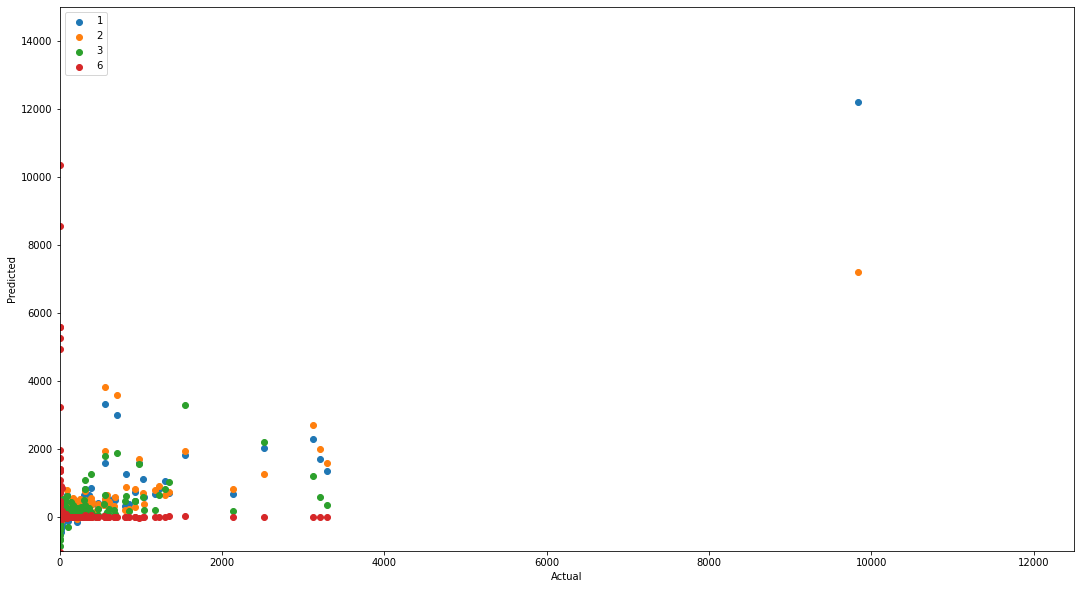

In [86]:
# POLYNOMIAL REGRESSION #2 retweet_count
#

# independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_verified']
# dependent_variables = 'favorite_count'
independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_verified']
dependent_variables = 'retweet_count'
degrees = [1, 2, 3, 6]

# excluding Outliners
# dfPoly = dfOriginals_Analyzed[dfOriginals_Analyzed[dependent_variables].between(dfOriginals_Analyzed[dependent_variables].quantile(.0015), dfOriginals_Analyzed[dependent_variables].quantile(0.9985))]
dfPoly = dfOriginals_Analyzed

trainSet=dfPoly.sample(frac=0.8,random_state=200)
testSet=dfPoly.drop(trainSet.index)


X_train = trainSet[independent_variables]
Y_train = trainSet[dependent_variables]
X_test = testSet[independent_variables]
Y_test = testSet[dependent_variables]

# y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

# calculate values for each degree
for i, degree in enumerate(degrees):    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
    model.fit(X_train, Y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    # y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)
  
# plot the graph
plt.figure(figsize=(40, 10))
plt.subplot(121)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.ylim([-1000,15000])
plt.xlim([0,12500])
for i, degree in enumerate(degrees):    
    plt.scatter(Y_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')


# print metrics
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    # train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
    test_r2 = round(r2_score(Y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: test score={1}".format(degree, test_r2))

# Step 12: Build Polynomial Regression K-fold

In [87]:
import math

independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_verified']
dependent_variables = 'favorite_count'
# independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_verified']
# dependent_variables = 'retweet_count'
# degrees = [1, 2 ]
degrees = [1, 2, 3, 6]
count = 0

kfold_n = 5
kfold_mse_total, kfold_rmse_total, kfold_rsqr_total = pd.DataFrame(0, index=np.arange(kfold_n), columns=degrees),pd.DataFrame(0, index=np.arange(kfold_n), columns=degrees),pd.DataFrame(0, index=np.arange(kfold_n), columns=degrees)
kf = KFold(n_splits = kfold_n, shuffle = True, random_state = 2)

# Excluding outliers, only including within 3-sigma
# dfKfold = dfOriginals_Analyzed[dfOriginals_Analyzed[dependent_variables].between(dfOriginals_Analyzed[dependent_variables].quantile(.0015), dfOriginals_Analyzed[dependent_variables].quantile(0.9985))]
dfPolyKfold = dfOriginals_Analyzed

kf_result = kf.split(dfPolyKfold)

print("Dependent Variable: {}".format(dependent_variables))
print("Independent Variables: {}".format(independent_variables))
print("K-fold: {}".format(kfold_n))
print("Polynomial\t\tRoot MSE\t\t\tR-Square\n=============================================================================================")

for train_idx, test_idx in kf_result:
  # print(train_idx)
  trainSet=dfPolyKfold.iloc[train_idx]
  testSet=dfPolyKfold.iloc[test_idx]

  X_train = trainSet[independent_variables]
  Y_train = trainSet[dependent_variables]
  X_test = testSet[independent_variables]
  Y_test = testSet[dependent_variables]

  reg = linear_model.LinearRegression()

  y_test_pred = np.zeros((len(X_test), len(degrees)))

  for i, degree in enumerate(degrees):    
    model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
    model.fit(X_train, Y_train)
    

    y_test_pred[:, i] = model.predict(X_test)

  
  
  for i, degree in enumerate(degrees):
    
    rsqr = round(r2_score(Y_test, y_test_pred[:, i]), 2)
    mse = mean_squared_error(Y_test, y_test_pred[:, i])
    print("Degree {0}: \t\t{1} \t\t{2}".format(degree, sqrt(mse),rsqr))
    row = math.floor(count/len(degrees))
    kfold_mse_total.loc[ row,degree ] = mse
    kfold_rmse_total.loc[ row,degree] = sqrt(mse)
    kfold_rsqr_total.loc[row,degree] = rsqr
    # print(f"count: {count}  row: {row}\n{kfold_rsqr_total.loc[row]}")
    count += 1
    


  print("---------------------------------------------------------------------------------")

polykfold_overall_metrics = list(zip(degrees,kfold_rmse_total.mean(),kfold_rsqr_total.mean()))
print('Degree\tAverage RMSE\tAverage R^2'.format(*el))
for el in polykfold_overall_metrics:
  print('{}\t{: 4f}\t{: 4f}'.format(*el))



Dependent Variable: favorite_count
Independent Variables: ['retweet_count', 'user_followers_count', 'compound', 'user_statuses_count', 'user_verified']
K-fold: 5
Polynomial		Root MSE			R-Square
Degree 1: 		176.1003309179579 		0.88
Degree 2: 		283.8671924780902 		0.69
Degree 3: 		906.2368606263769 		-2.18
Degree 6: 		856.3979925552468 		-1.84
---------------------------------------------------------------------------------
Degree 1: 		101.57117876732413 		0.71
Degree 2: 		113.61553501192776 		0.64
Degree 3: 		164.8107158447843 		0.24
Degree 6: 		1067.8173629126154 		-30.98
---------------------------------------------------------------------------------
Degree 1: 		361.7648735168686 		0.37
Degree 2: 		578.1225176563707 		-0.6
Degree 3: 		10089.810890024544 		-485.89
Degree 6: 		38011377.335343964 		-6910168447.01
---------------------------------------------------------------------------------
Degree 1: 		106.07747474685985 		0.76
Degree 2: 		132.28407898975604 		0.63
Degree 3: 		429.97

In [88]:
# K-fold Poly #2 Retweet

import math

# independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_verified']
# dependent_variables = 'favorite_count'
independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_verified']
dependent_variables = 'retweet_count'
# degrees = [1, 2 ]
degrees = [1, 2, 3, 6]
count = 0

kfold_n = 5
kfold_mse_total, kfold_rmse_total, kfold_rsqr_total = pd.DataFrame(0, index=np.arange(kfold_n), columns=degrees),pd.DataFrame(0, index=np.arange(kfold_n), columns=degrees),pd.DataFrame(0, index=np.arange(kfold_n), columns=degrees)
kf = KFold(n_splits = kfold_n, shuffle = True, random_state = 2)

# Excluding outliers, only including within 3-sigma
dfPolyKfold = dfOriginals_Analyzed

kf_result = kf.split(dfPolyKfold)

print("Dependent Variable: {}".format(dependent_variables))
print("Independent Variables: {}".format(independent_variables))
print("K-fold: {}".format(kfold_n))
print("Polynomial\t\tRoot MSE\t\t\tR-Square\n=============================================================================================")

for train_idx, test_idx in kf_result:
  trainSet=dfPolyKfold.iloc[train_idx]
  testSet=dfPolyKfold.iloc[test_idx]

  X_train = trainSet[independent_variables]
  Y_train = trainSet[dependent_variables]
  X_test = testSet[independent_variables]
  Y_test = testSet[dependent_variables]

  reg = linear_model.LinearRegression()

  y_test_pred = np.zeros((len(X_test), len(degrees)))

  for i, degree in enumerate(degrees):    
    model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
    model.fit(X_train, Y_train)
    

    y_test_pred[:, i] = model.predict(X_test)

  
  
  for i, degree in enumerate(degrees):
    
    rsqr = round(r2_score(Y_test, y_test_pred[:, i]), 2)
    mse = mean_squared_error(Y_test, y_test_pred[:, i])
    print("Degree {0}: \t\t{1} \t\t{2}".format(degree, sqrt(mse),rsqr))
    row = math.floor(count/len(degrees))
    kfold_mse_total.loc[ row,degree ] = mse
    kfold_rmse_total.loc[ row,degree] = sqrt(mse)
    kfold_rsqr_total.loc[row,degree] = rsqr
    # print(f"count: {count}  row: {row}\n{kfold_rsqr_total.loc[row]}")
    count += 1
    


  print("---------------------------------------------------------------------------------")

polykfold_overall_metrics = list(zip(degrees,kfold_rmse_total.mean(),kfold_rsqr_total.mean()))
print('Degree\tAverage RMSE\tAverage R^2'.format(*el))
for el in polykfold_overall_metrics:
  print('{}\t{: 4f}\t{: 4f}'.format(*el))



Dependent Variable: retweet_count
Independent Variables: ['favorite_count', 'user_followers_count', 'compound', 'user_statuses_count', 'user_verified']
K-fold: 5
Polynomial		Root MSE			R-Square
Degree 1: 		30.619157472439177 		0.95
Degree 2: 		143.57465611146827 		-0.12
Degree 3: 		197.92059429558387 		-1.13
Degree 6: 		140.91449714880363 		-0.08
---------------------------------------------------------------------------------
Degree 1: 		27.778555948274388 		0.62
Degree 2: 		33.17703268992806 		0.46
Degree 3: 		44.99600146557491 		-0.0
Degree 6: 		1595.006459641652 		-1256.94
---------------------------------------------------------------------------------
Degree 1: 		105.01778633851833 		0.68
Degree 2: 		109.10569803537199 		0.66
Degree 3: 		1123.4793102354063 		-35.19
Degree 6: 		185441.21308761396 		-986024.03
---------------------------------------------------------------------------------
Degree 1: 		28.269222892920038 		0.73
Degree 2: 		47.405288929894574 		0.23
Degree 3: 		55.0